In [1]:
import os
import sys
import glob
import re

import random 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import decoupler

import scanpy as sc
#from kneed import KneeLocator 

import pandas as pd

import session_info
import warnings
from pyprojroot.here import here

sys.path.insert(1, str(here('bin')))

# Import custom functions
from customPythonFunctions import get_HVG

from customPalette import diseaseCategories

#plt.style.use(['science','nature','no-latex'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

# Setting some parameters
warnings.filterwarnings("ignore")

overwriteData = True
overwriteFigures = True

# Set random seed
random_seed = 42

### Load single-cell data

In [2]:
# Load the h5ad file
adata = sc.read_h5ad(here("02_fromCellLineages_to_CellTypes/INFLAMMATION_main_annotated_LowQFilt.h5ad"))

## Differential expressed genes among disease

We are going to use edgeR to obtain the list of DEG doing pair-wise comparisong among diseases.

The confounding variables that we want to include are *'ILCIC_source'* (that accounts for technical biases, e.g., different platform technologies). Plus, *'sex'*, and *'binned_age'*, for accounting for biological factors.

Following single-cell best practice guideline [https://www.sc-best-practices.org/conditions/differential_gene_expression.html], we chose to apply a pseudobulk approach via edgeR. Therefore, the first step is to generate the pseudobulk of cell-type at the patient levels. 

Considering that we don't have replicates, we will generate multiple pseudobulks for each patients. Doing this, we will also reduce the impact of different number of cell per patients.

We will consider only the following main cell groups: 'B', 'DC', 'ILC', 'Mono', 'Plasma', 'T_CD4_Naive', 'T_CD4_NonNaive', 
'T_CD8_Naive', 'T_CD8_NonNaive', 'UTC', 'pDC'. Thus, removing **RBC** and **Platelets** (low quality). We are also removing **Cycling_cell** and **Progenitors** because the impact of the proliferation could bias the gene selection, while Progenitors are not expected to be present in blood. However, we will keep them in the integrated object and we will check signature changes over those cells.

For this task we will use **get_pseudobulk** function from *decoupler* package 

In [5]:
adataCTsel = adataPfilt[~adataPfilt.obs.Level1.isin(['RBC', 'Platelets','Cycling_cells','Progenitors'])]
#adataCTsel.layers['counts'] = adataCTsel.X

In [6]:
adataCTsel.obs.Level1.unique().tolist()

['T_CD8_NonNaive',
 'T_CD4_Naive',
 'Mono',
 'T_CD4_NonNaive',
 'ILC',
 'B',
 'T_CD8_Naive',
 'DC',
 'pDC',
 'UTC',
 'Plasma']

**Removing genes with less then 1 count in each dataset**

In [7]:
psbulk_study = decoupler.get_pseudobulk(adata=adataCTsel, 
                                 min_cells=0, 
                                 sample_col = 'studyID',
                                 groups_col=None, 
                                 layer=None,#'counts', 
                                 mode='sum')

In [8]:
# Keeping only genes with 0 entries equal to 0. In other words, keeping genes with at least 1 read count in each dataset
genesToKeep = psbulk_study.var[np.sum(psbulk_study.X == 0, axis = 0) == 0]

In [9]:
print('Genes kept')
adataCTsel[:,adataCTsel.var_names.isin(genesToKeep.index)].var.HUGO_status.value_counts()

Genes kept


HUGO_status
official        14342
non-official       15
Name: count, dtype: int64

In [10]:
print('Genes removed')
adataCTsel[:,~adataCTsel.var_names.isin(genesToKeep.index)].var.HUGO_status.value_counts()

Genes removed


HUGO_status
official        4430
non-official    4051
Name: count, dtype: int64

### Generating pseudo-bulk

#### Removing patients with main clinical information not available (i.e., sex or binned_age)

In [11]:
adataCTsel = adataCTsel[~((adataCTsel.obs['sex'].isna()) | (adataCTsel.obs['binned_age'].isna()))]

In [12]:
adataCTsel.obs.isna().sum()

studyID       0
libraryID     0
sampleID      0
chemistry     0
disease       0
sex           0
binned_age    0
Level1        0
Level2        0
dtype: int64

In [13]:
min_cells = 20

In [14]:
pbdata = decoupler.get_pseudobulk(adata=adataCTsel, 
                                 min_cells=min_cells, 
                                 sample_col = 'sampleID',
                                 groups_col='Level1', 
                                 layer=None,#'counts', 
                                 mode='sum')

In [15]:
diseaseCategories

{'healthy': 'healthy',
 'RA': 'IMIDs',
 'CD': 'IMIDs',
 'UC': 'IMIDs',
 'PS': 'IMIDs',
 'SLE': 'IMIDs',
 'PSA': 'IMIDs',
 'MS': 'IMIDs',
 'asthma': 'chronic_inflammation',
 'COPD': 'chronic_inflammation',
 'cirrhosis': 'chronic_inflammation',
 'sepsis': 'acute_inflammation',
 'HIV': 'infection',
 'HBV': 'infection',
 'COVID': 'infection',
 'flu': 'infection',
 'HNSCC': 'solid_tumor',
 'BRCA': 'solid_tumor',
 'NPC': 'solid_tumor',
 'CRC': 'solid_tumor'}

In [16]:
pbdata.obs['disease_cat'] = pbdata.obs.disease.map(diseaseCategories)

### Exploring variation across pseudobulks

In [17]:
pbdata.layers['counts'] = pbdata.X.copy()
#pbdata.X = pbdata.layers['counts'].copy()

**Excluding specific genes based on literature**

We have reasoned that T- and B- cell receptors genes, including VDJ joining and variable regions, are not useful to describe cell identities but rather to capture (generally) patient specific cell populations that are suffering clonal expansion within a specific pathological / inflammatory condition. Thus, we decided to exclude TCR and BCR genes as well as genes related with the Major Histocompatibility Complex (MHC) from the list of HVG selection that we will use to perform data integration. Additionally, we also decided to drop genes related to the mitochondrial and ribosomal organules since these might be largely biased due to different technical effects.

Although we are not really interested in studying neither to genes exclusive from to Red Blood Cells (such as hemoglobin) or Platelets (such as PPBP), we will keep them in order to be able to identify specific cell subsets we are not interested in (RBC or Platelets) and to better delineate the inflammation cell identity profile, such as these ones being very transcriptionally active. Then, once RBC and Platelets removed from our dataset, we will also exclude them.

In [27]:
# Retrieve MT and RB genes present in the dataset
MT_gene_idx = pbdata.var["symbol"].str.startswith("MT-")
print(f"{np.sum(MT_gene_idx)} mitochondrial genes")

RB_gene_idx = pbdata.var["symbol"].str.startswith(("RPS", "RPL"))
print(f"{np.sum(RB_gene_idx)} ribosomal genes")

# Retrieve TCR and BCR present in the dataset
TCR_gene_idx = pbdata.var["symbol"].str.contains("^TRA(J|V)|^TRB(J|V|D)")
print(f"{np.sum(TCR_gene_idx)} TCR genes")

BCR_gene_idx = pbdata.var["symbol"].str.contains("^IGH(J|V)")
print(f"{np.sum(BCR_gene_idx)} TCR genes")

HB_gene_idx = pbdata.var["symbol"].str.contains("^HB[^(P)]")
print(f"{np.sum(HB_gene_idx)} HB genes")

# Some of those genes will be included anyway because are part of curated gene sets.
MHC_gene_idx = pbdata.var["symbol"].str.contains("^HLA-")
print(f"{np.sum(MHC_gene_idx)} MHC genes")

PLT_gene_idx = pbdata.var["symbol"].isin(["PPBP", "PDGF", "ANG1", "LAPTM4B", "WASF3", "TPM3", "PF4", "TAC1"])
print(f"{np.sum(PLT_gene_idx)} PLT genes")

exclude_gene_idx = (MT_gene_idx | RB_gene_idx | TCR_gene_idx | BCR_gene_idx | HB_gene_idx | MHC_gene_idx | PLT_gene_idx )

pbdataNoUnwanted = pbdata[:, ~exclude_gene_idx]
pbdataNoUnwanted

13 mitochondrial genes
110 ribosomal genes
118 TCR genes
54 TCR genes
11 HB genes
21 MHC genes
5 PLT genes


View of AnnData object with n_obs × n_vars = 7357 × 22506
    obs: 'studyID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'Level1', 'psbulk_n_cells', 'psbulk_counts', 'disease_cat'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'
    layers: 'psbulk_props', 'counts'

**Keeping only genes detected in each study**

We keep only genes that are detected with at least 1 count in each study. Those genes were defined above

In [28]:
pbdataFilt = pbdataNoUnwanted[:,pbdataNoUnwanted.var_names.isin(genesToKeep.index)]
pbdataFilt

View of AnnData object with n_obs × n_vars = 7357 × 14101
    obs: 'studyID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'Level1', 'psbulk_n_cells', 'psbulk_counts', 'disease_cat'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'
    layers: 'psbulk_props', 'counts'

In [29]:
genes = pbdataFilt.var

#### Performing PCA

In [31]:
sc.pp.normalize_total(pbdata, target_sum=1e6)
sc.pp.log1p(pbdata)

sc.pp.pca(pbdata, zero_center=True)

In [32]:
sc.pp.normalize_total(pbdataFilt, target_sum=1e6)
sc.pp.log1p(pbdataFilt)

sc.pp.pca(pbdataFilt, zero_center=True)

#### Considering all the genes

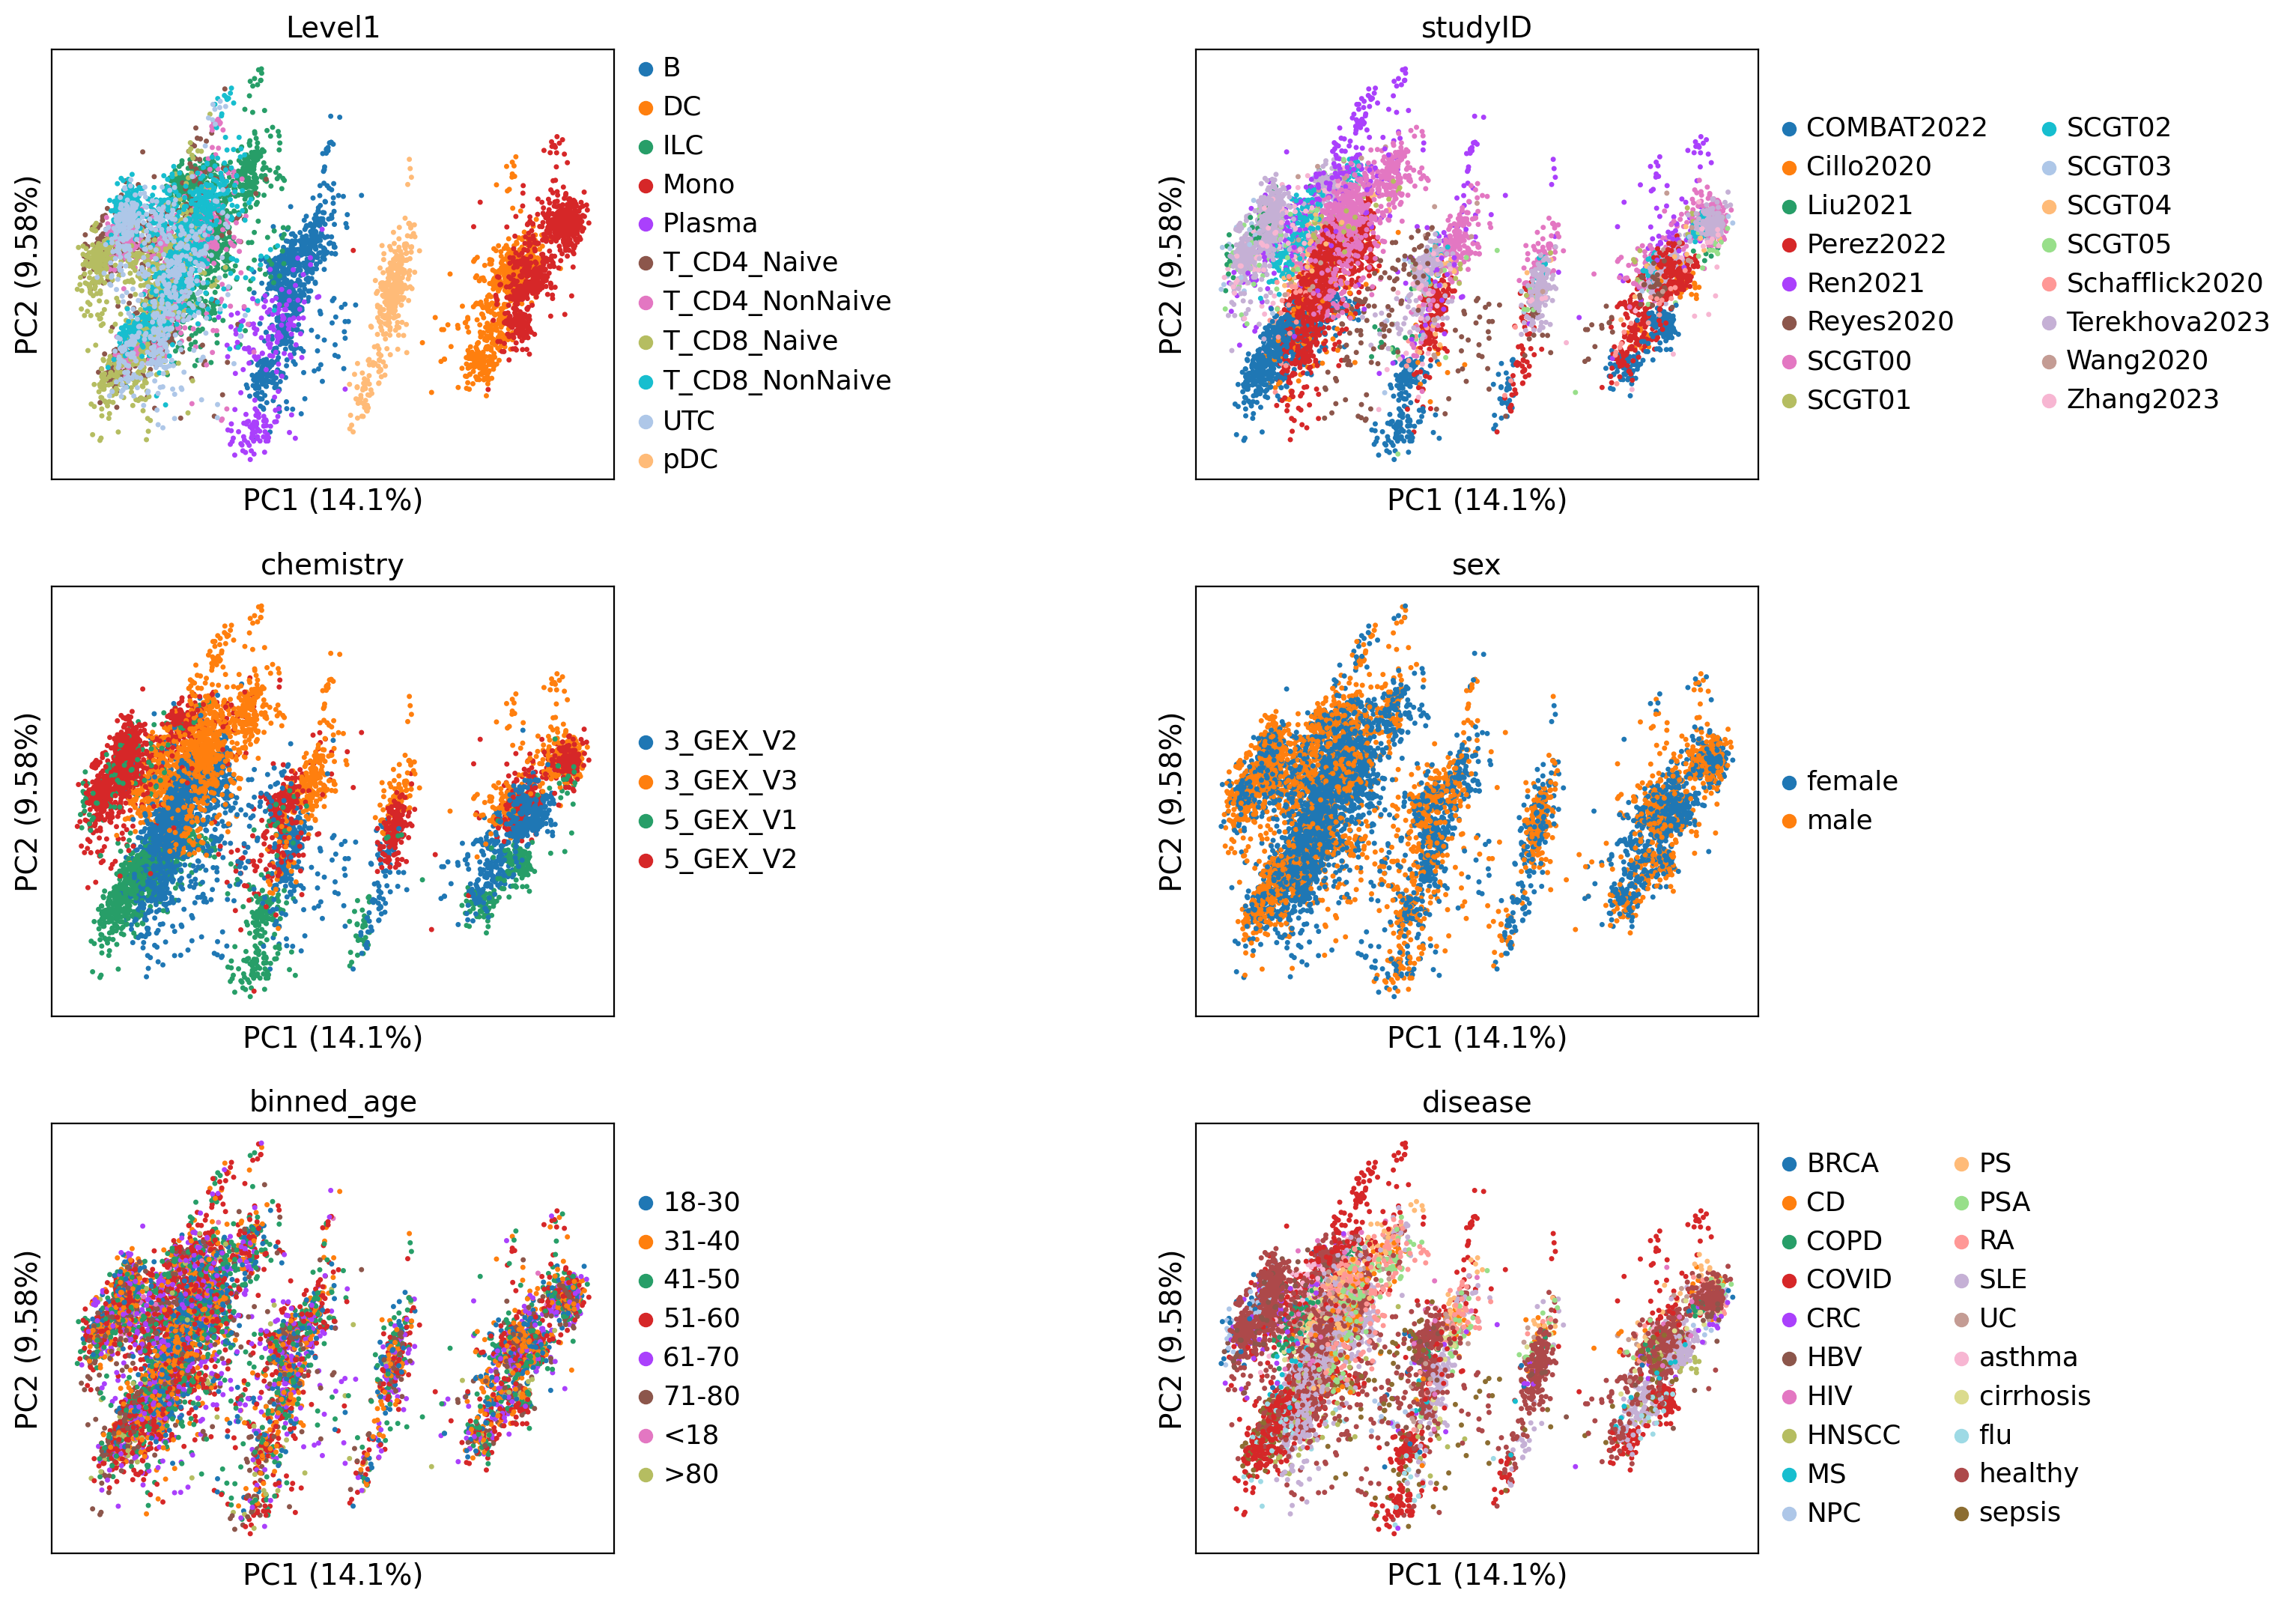

In [33]:
sc.pl.pca(pbdata, color=pbdata.obs[['Level1',
                                    'studyID',
                                    'chemistry',
                                    #'technology',
                                    'sex',
                                    'binned_age',
                                    'disease',
                                    #'disease_cat'
                                   ]], 
          ncols=2, size=25, wspace=0.85, annotate_var_explained=True)

#### Removing genes not detected in all studies

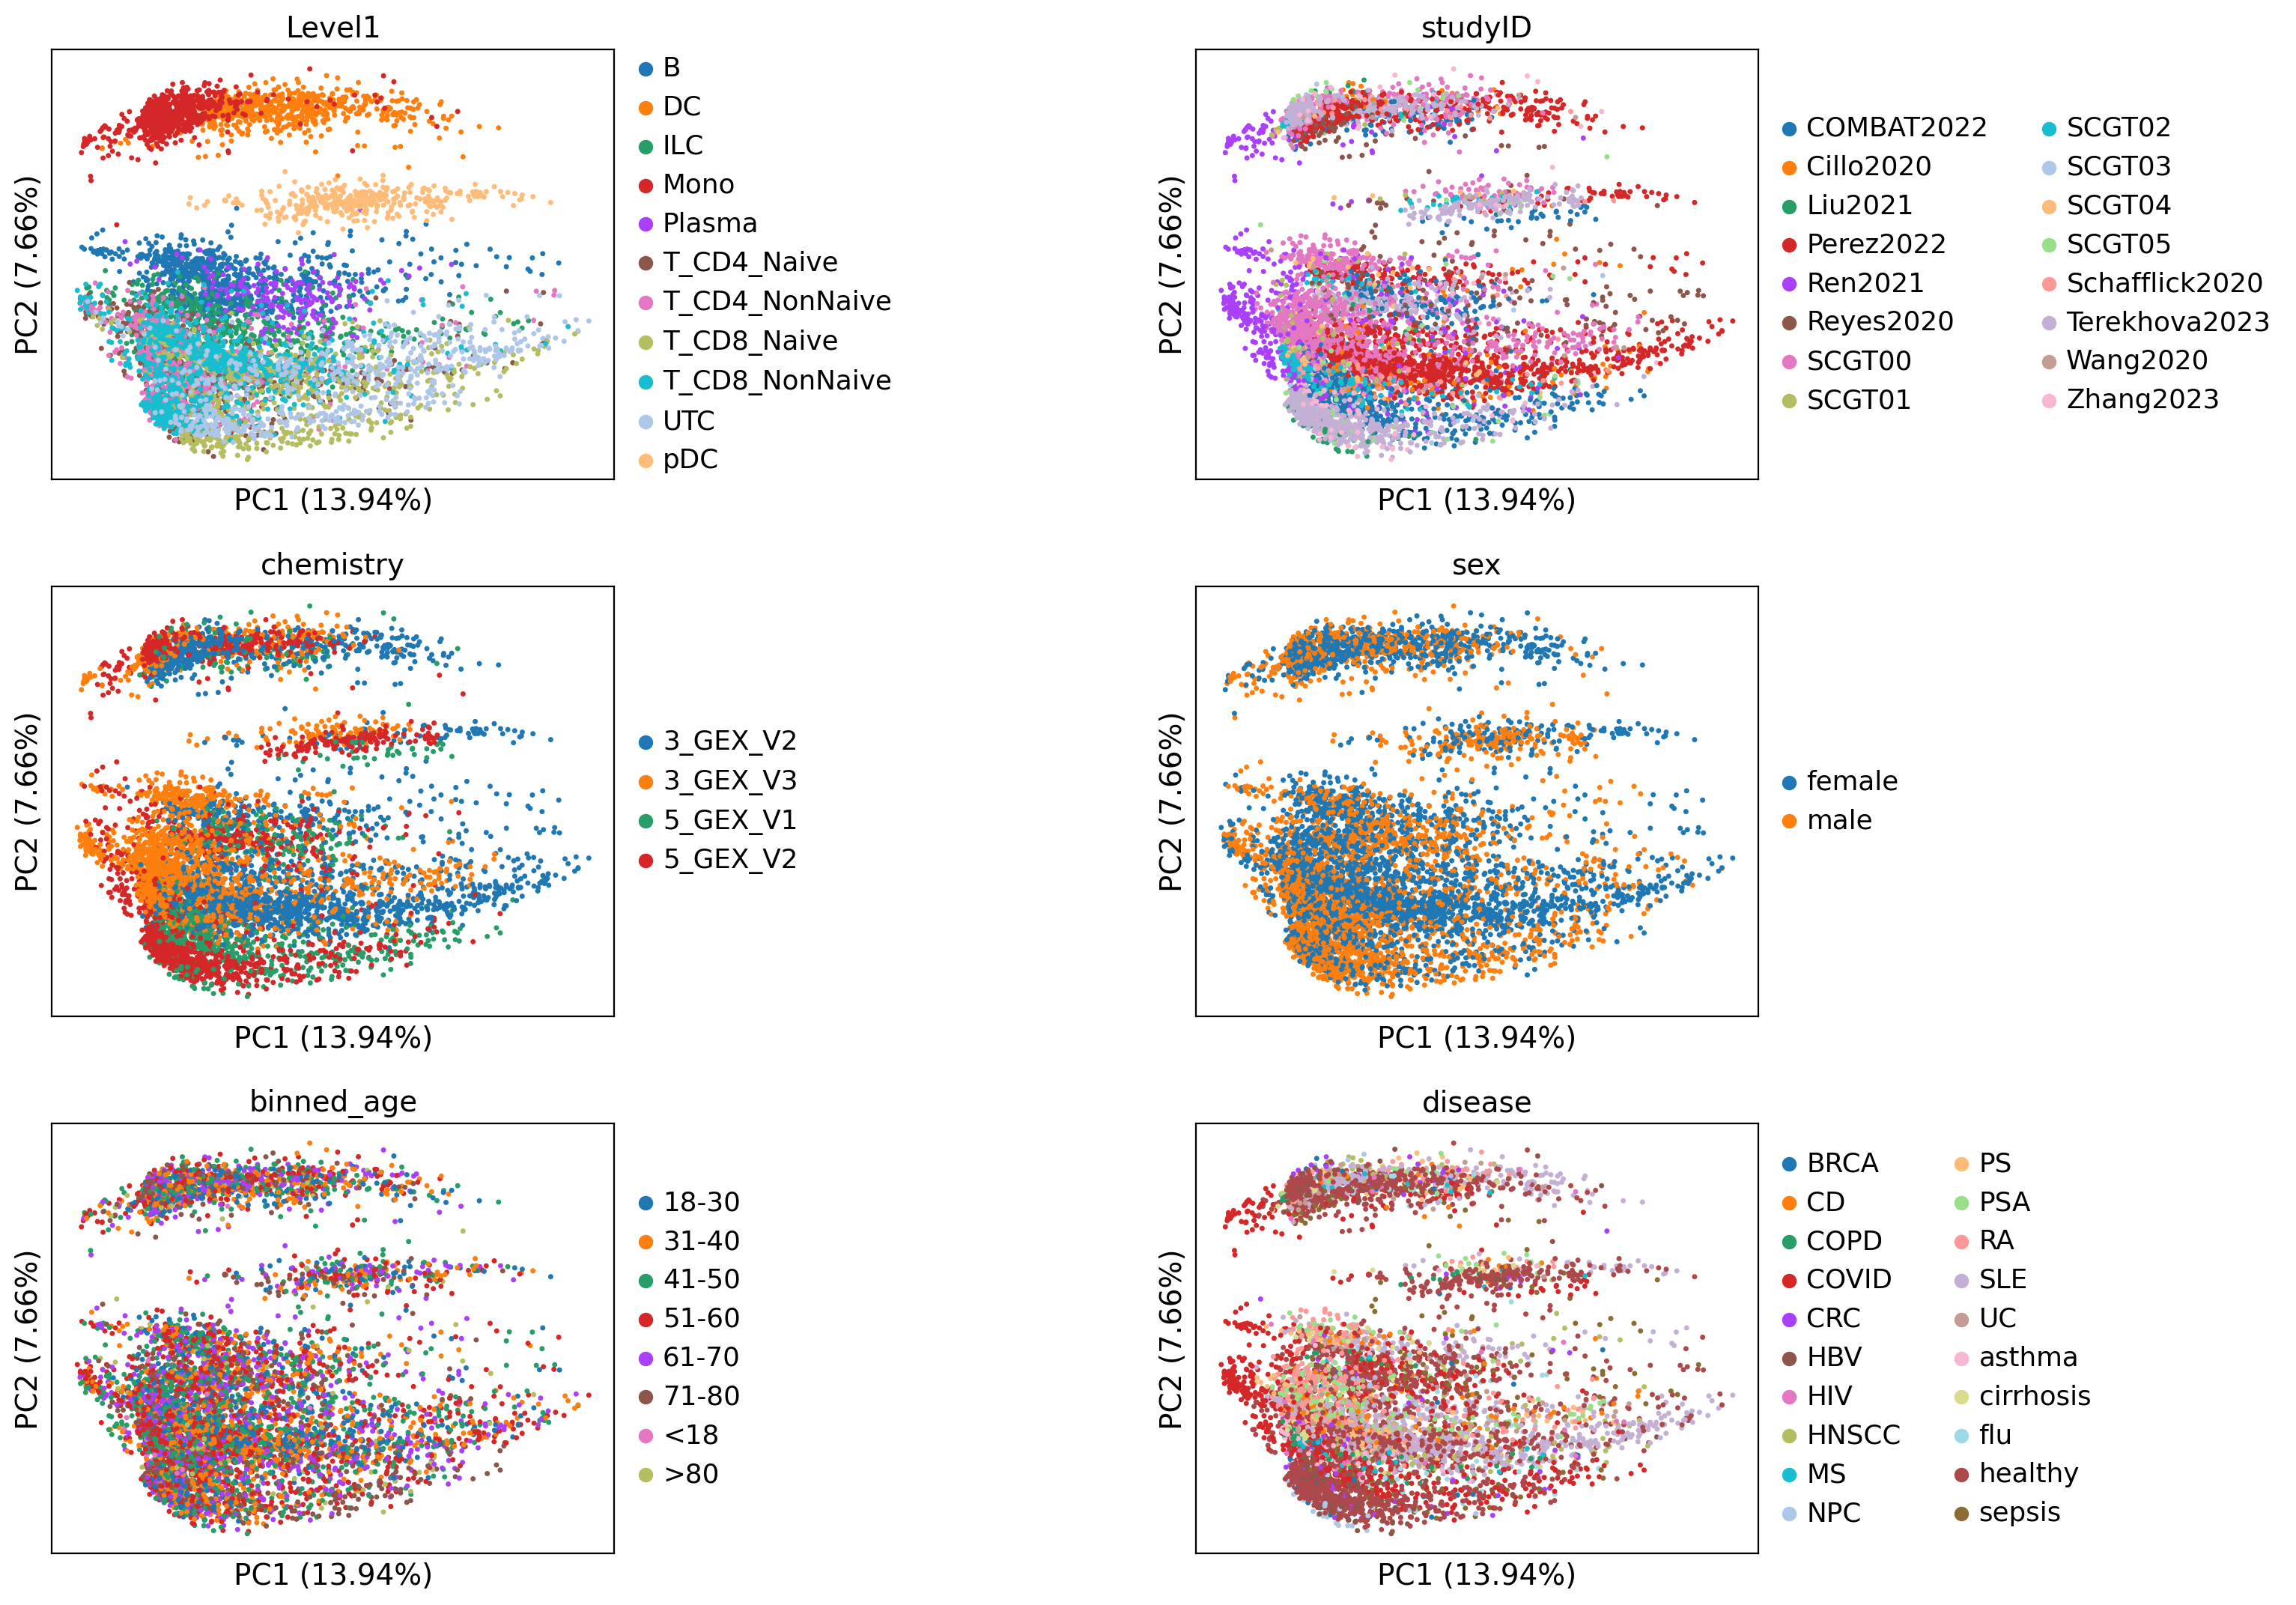

In [34]:
sc.pl.pca(pbdataFilt, color=pbdata.obs[['Level1',
                                    'studyID',
                                    'chemistry',
                                    #'technology',
                                    'sex',
                                    'binned_age',
                                    'disease',
                                    #'disease_cat'
                                       ]], 
          ncols=2, size=25, wspace=0.85, annotate_var_explained=True)

### Regression among PCs and covariates

In [35]:
def lm_covariate_PCs(adata=None, covariates = None):
    import pandas as pd
    from sklearn.linear_model import LinearRegression

    resDF = pd.DataFrame()
    PCs = adata.obsm['X_pca']
    for cov_i in covariates:
        dummieCov = pd.get_dummies(adata.obs[cov_i])        
        r2 = []
        for i in range(PCs.shape[1]):
            pc = PCs[:, [i]]
            lm = LinearRegression()
            lm.fit(dummieCov, pc)
            r2_score = np.maximum(0, lm.score(dummieCov, pc))
            r2.append(r2_score)
        resDF = pd.concat([resDF,pd.DataFrame(r2)], axis=1)
        
    resDF.columns = covariates
    return(resDF)

In [36]:
resAllGene = lm_covariate_PCs(adata=pbdata, covariates = ['disease', 'Level1', 'chemistry',
                                                          #'technology', 
                                                          'studyID','binned_age', 'sex'])
resFilt = lm_covariate_PCs(adata=pbdataFilt, covariates = ['disease', 'Level1', 'chemistry',
                                                           #'technology', 
                                                           'studyID','binned_age', 'sex'])

In [37]:
import seaborn as sns

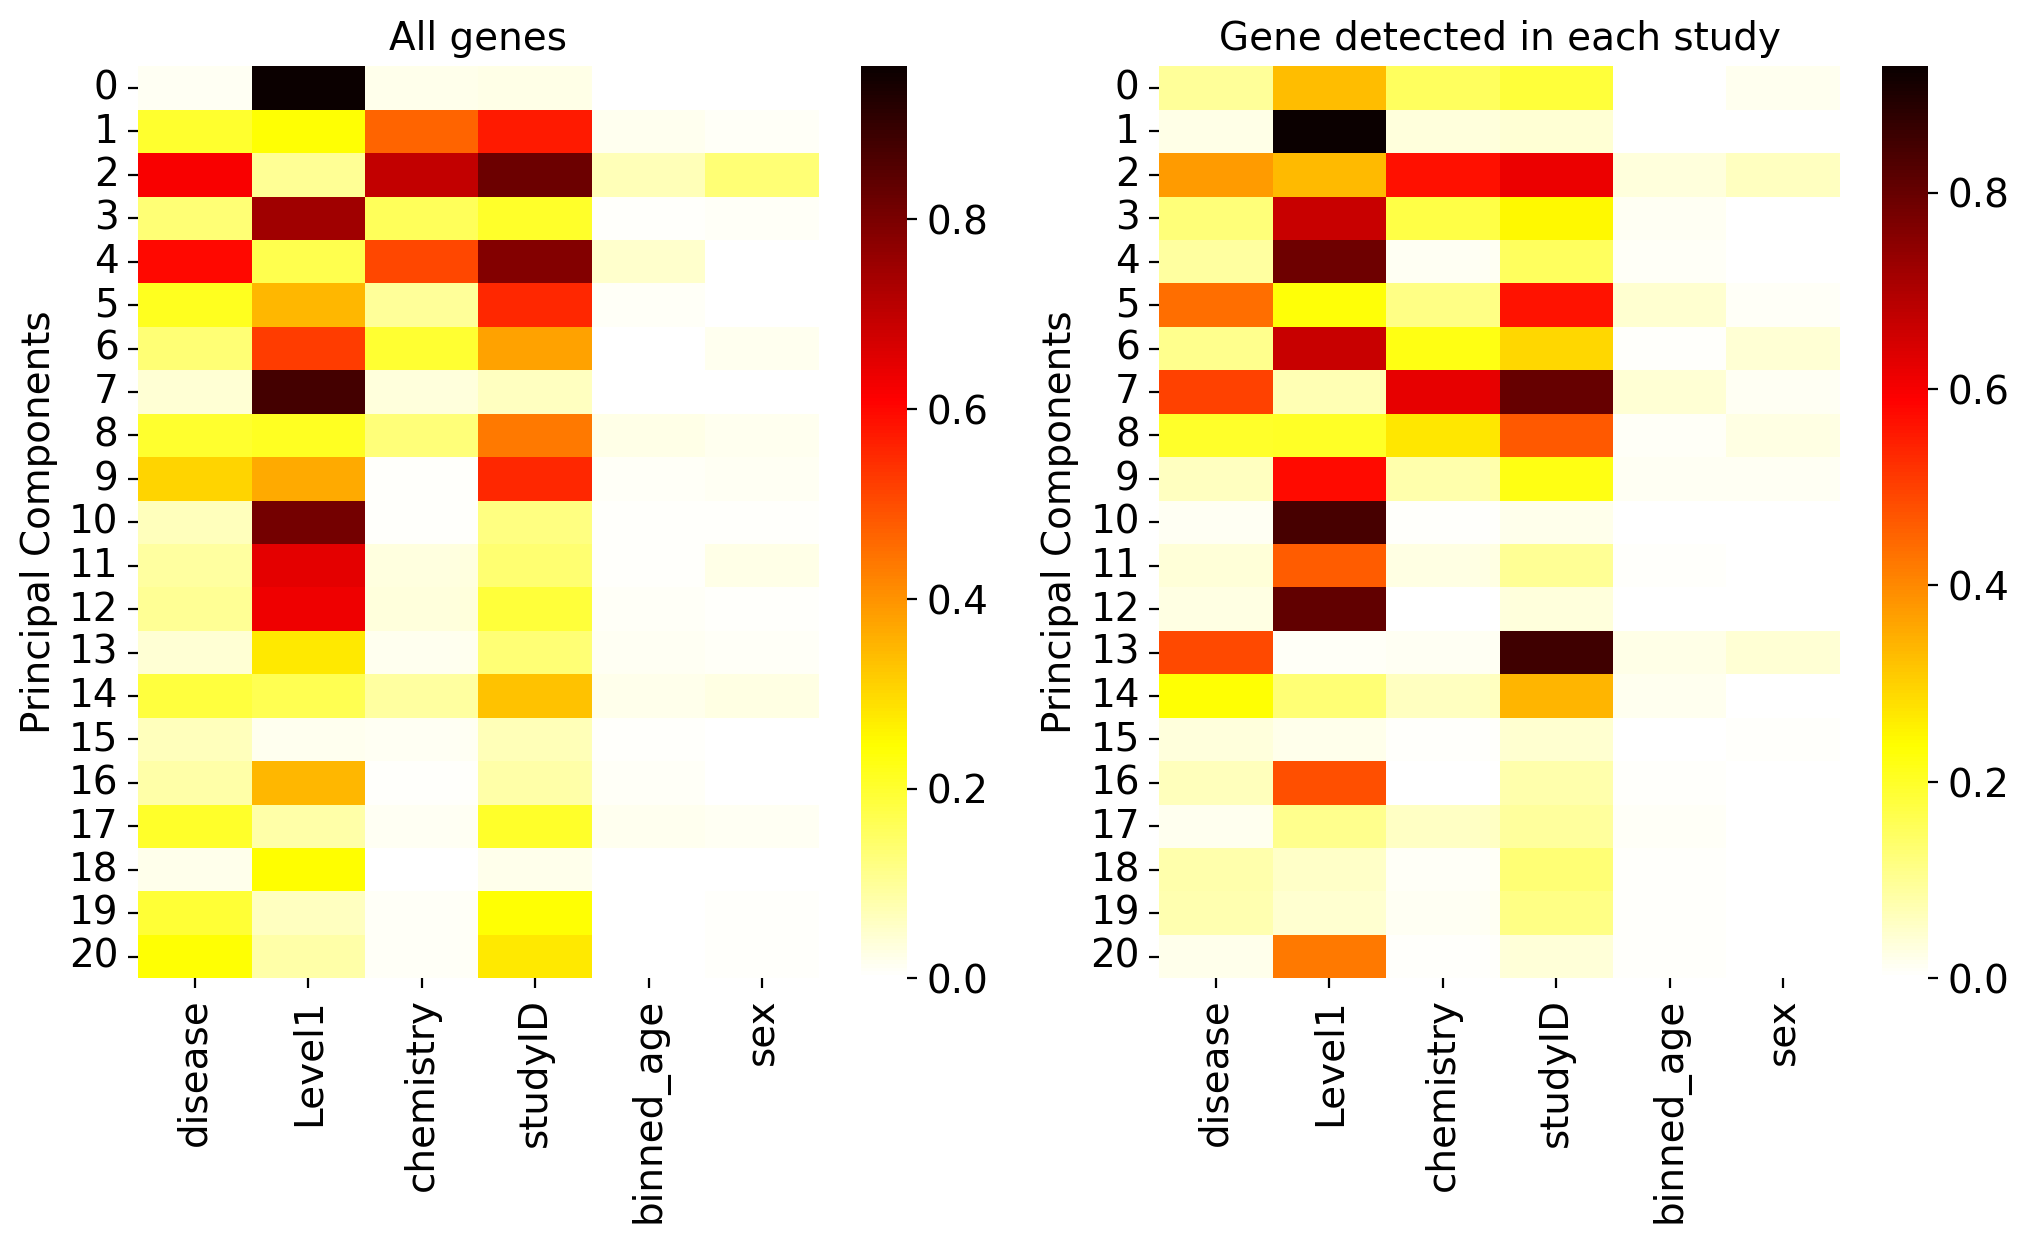

In [38]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))  # Set the width and height of the figure

sns.heatmap(resAllGene.loc[0:20,], ax=axs[0], cmap = 'hot_r')
axs[0].set_title('All genes')
axs[0].set_ylabel('Principal Components')
axs[0].grid(False)

sns.heatmap(resFilt.loc[0:20,], ax=axs[1], cmap = 'hot_r')
axs[1].set_title('Gene detected in each study')
axs[1].set_ylabel('Principal Components')
axs[1].grid(False)

plt.show()

We decided to use the filtered object. Because genes that are not detected with at least one count in each study, are more likely to be related to batch effect. 

### Saving the pseudobulk object

In [39]:
selectedPseudobulAdata = pbdataFilt.copy()

In [40]:
# restoring raw counts and removing useless data before moving to R
selectedPseudobulAdata.X = selectedPseudobulAdata.layers['counts'].copy()

In [41]:
del selectedPseudobulAdata.layers
del selectedPseudobulAdata.obsm
del selectedPseudobulAdata.varm
del selectedPseudobulAdata.uns

In [42]:
selectedPseudobulAdata.obs.head()

studyID              sampleID chemistry disease  \
COMBAT2022_G05061_T0_B  COMBAT2022  COMBAT2022_G05061_T0  5_GEX_V1   COVID   
COMBAT2022_G05064_T0_B  COMBAT2022  COMBAT2022_G05064_T0  5_GEX_V1   COVID   
COMBAT2022_G05077_T0_B  COMBAT2022  COMBAT2022_G05077_T0  5_GEX_V1   COVID   
COMBAT2022_G05078_T0_B  COMBAT2022  COMBAT2022_G05078_T0  5_GEX_V1   COVID   
COMBAT2022_G05105_T0_B  COMBAT2022  COMBAT2022_G05105_T0  5_GEX_V1   COVID   

                           sex binned_age Level1  psbulk_n_cells  \
COMBAT2022_G05061_T0_B  female      51-60      B           410.0   
COMBAT2022_G05064_T0_B  female      51-60      B           318.0   
COMBAT2022_G05077_T0_B    male      41-50      B           341.0   
COMBAT2022_G05078_T0_B    male      31-40      B           129.0   
COMBAT2022_G05105_T0_B  female      51-60      B           384.0   

                        psbulk_counts disease_cat  
COMBAT2022_G05061_T0_B      1304420.0   infection  
COMBAT2022_G05064_T0_B       929381.0   infection  
COMBAT2022_G05077_T0_B      1183383.0   infection  
COMBAT2022_G05078_T0_B       414562.0   infection  
COMBAT2022_G05105_T0_B      1333988.0   infection

In [43]:
if overwriteData:
    selectedPseudobulAdata.write_h5ad(here("03_downstream_analysis/02_gene_universe_definition/results/01_INFLAMMATION_annotated_pseudobulk.h5ad"))

In [44]:
# SAVING PRE-SELECTED GENES FOR HVG notebook 
# (no unwanted genes and only genes detected with at least 1 count in each study)
if overwriteData:
    selectedPseudobulAdata.var[['hgnc_id', 'symbol']].to_pickle(here("03_downstream_analysis/02_gene_universe_definition/results/02_preselectedGenes.pkl"))

In [50]:
session_info.show()

In [64]:
geneRemoved = adata.var[~adata.var.index.isin(pbdataFilt.var.index)]

In [65]:
geneRemoved

hgnc_id           symbol     locus_group   HUGO_status
ensembl_gene_id                                                           
ENSG00000001617  HGNC:10728           SEMA3F  protein_coding      official
ENSG00000001626   HGNC:1884             CFTR  protein_coding      official
ENSG00000003989  HGNC:11060           SLC7A2  protein_coding      official
ENSG00000005981  HGNC:16009             ASB4  protein_coding      official
ENSG00000006042  HGNC:24529           TMEM98  protein_coding      official
...                     ...              ...             ...           ...
ENSG00000288253         NaN  ENSG00000288253          lncRNA  non-official
ENSG00000288302         NaN     LOC124903386          lncRNA  non-official
ENSG00000288398         NaN  ENSG00000288398          lncRNA  non-official
ENSG00000288558  HGNC:54422     DUS4L-BCAP29           other      official
ENSG00000288596  HGNC:25646          C8orf44           other      official

[8737 rows x 4 columns]

In [66]:
# Retrieve MT and RB genes present in the dataset
MT_gene_idx = geneRemoved["symbol"].str.startswith("MT-")
print(f"{np.sum(MT_gene_idx)} mitochondrial genes")

RB_gene_idx = geneRemoved["symbol"].str.startswith(("RPS", "RPL"))
print(f"{np.sum(RB_gene_idx)} ribosomal genes")

# Retrieve TCR and BCR present in the dataset
TCR_gene_idx = geneRemoved["symbol"].str.contains("^TRA(J|V)|^TRB(J|V|D)")
print(f"{np.sum(TCR_gene_idx)} TCR genes")

BCR_gene_idx = geneRemoved["symbol"].str.contains("^IGH(J|V)")
print(f"{np.sum(BCR_gene_idx)} TCR genes")

HB_gene_idx = geneRemoved["symbol"].str.contains("^HB[^(P)]")
print(f"{np.sum(HB_gene_idx)} HB genes")

# Some of those genes will be included anyway because are part of curated gene sets.
MHC_gene_idx = geneRemoved["symbol"].str.contains("^HLA-")
print(f"{np.sum(MHC_gene_idx)} MHC genes")

PLT_gene_idx = geneRemoved["symbol"].isin(["PPBP", "PDGF", "ANG1", "LAPTM4B", "WASF3", "TPM3", "PF4", "TAC1"])
print(f"{np.sum(PLT_gene_idx)} PLT genes")

exclude_gene_idx = (MT_gene_idx | RB_gene_idx | TCR_gene_idx | BCR_gene_idx | HB_gene_idx | MHC_gene_idx | PLT_gene_idx )

13 mitochondrial genes
110 ribosomal genes
118 TCR genes
54 TCR genes
11 HB genes
21 MHC genes
5 PLT genes


In [69]:
geneRemoved.loc[MHC_gene_idx].index.tolist()

['ENSG00000179344',
 'ENSG00000196126',
 'ENSG00000196735',
 'ENSG00000198502',
 'ENSG00000204252',
 'ENSG00000204257',
 'ENSG00000204287',
 'ENSG00000204525',
 'ENSG00000204592',
 'ENSG00000204632',
 'ENSG00000204642',
 'ENSG00000206503',
 'ENSG00000214922',
 'ENSG00000223534',
 'ENSG00000223865',
 'ENSG00000231389',
 'ENSG00000232629',
 'ENSG00000234745',
 'ENSG00000237541',
 'ENSG00000241106',
 'ENSG00000242574']